In [1]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F
import os
log_dir = "DDPG"
os.makedirs(log_dir, exist_ok=True)
from tqdm import tqdm 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


First of all, we will start with the following equation (Bellman equation) discussed in [Q-Learning](./01-q-learning.ipynb) :

$$ Q^{*}(s_t,a_t) = r_t + \gamma \max_a{Q(s_{t+1},a)} \;\;\;\;\;\; (1)$$

where $ Q^{*} $ means the optimal $ Q $ value.

Now we consider Q-network $ Q_{\phi} $ where $\phi$ is parameters.<br>
To optimize the equation (1), we should find $\phi$ to minimize the following loss $L$ for tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \max_a{Q_{\phi}(s_{t+1},a)} \right) \right)^2 \right] \;\;\;\;\;\; (2)$$

where $d_t = 1$ if the episode is done, and $0$ otherwise.

To make the above maximization $\max_a Q_{\phi}(s_{t+1}, a)$ work in continuous action space, we introduce the action policy $\mu_{\theta}(s)$, with which we'll find $\theta$ to maximize $ Q_{\phi}(s, \mu_{\theta}(s)) $.<br>
The equation (2) will then be written as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{\phi}(s_{t+1},\mu_{\theta}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (3) $$

> Note : As you will find, this will again be based on [Actor-Critic method](./03-actor-critic.ipynb) which separates policy ($\mu_{\theta}$) and value evaluation ($Q_{\phi}$) in algorithm.

Please take care for the difference between this policy $\mu_{\theta}(s)$ and a policy used in [on-policy](./02-policy-gradient.ipynb) method. Here $\mu_{\theta}(s)$ is deterministic and it doesn't care how the action space is distributed, unlike $ P(a | \pi_\theta (s)) $ in on-policy methods. (This is because DDPG is called "deterministic" and it's in off-policy method.)

To make the minimization (3) stable, we also introduce the separated parameters $\phi^{\prime}$ and $\theta^{\prime}$ (called **target**) as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{{\phi}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (4) $$

And these parameters are delayed with coefficient parameter (hyper-parameter) $ \tau $ (which is near 0) after each training.

$ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $

$ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

To summarize algorithm :

- Collect tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $
- Optimize $ \phi $ to minimize $L$ in (4)
- Optimize $ \theta $ to maximize $Q_{\phi}(s, \mu_{\theta}(s))$
- Update target parameters as follows
    - $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
    - $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

Now let's start building networks.

## 1. Q-network

First, we build Q-network (both $Q_{\phi}(s, a)$ and $Q_{{\phi}^{\prime}}(s, a)$) as follows.

In [2]:
env = gym.make("MountainCarContinuous-v0") 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#env = gym.make("LunarLander-v2",continuous = True,gravity = -10.0,enable_wind = False,wind_power = 15.0,turbulence_power = 1.5,)
batch_size = 250

n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
print(n_states)
print(n_actions)
hidden_dim = 512

2
1


In [3]:
class QNet(nn.Module):
    def __init__(self, n_in, hidden_dim=64):
        super().__init__()

        self.hidden1 = nn.Linear(n_in, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, int(hidden_dim//2))
        self.output = nn.Linear(int(hidden_dim//2), 1)

    def forward(self, s, a):
        #print('S', s.shape, s)
        #print('A', a.shape)
        outs = torch.concat((s, a), dim=-1)
        #print(outs.shape)
        outs = self.hidden1(outs)
        outs = F.relu(outs)
        outs = self.hidden2(outs)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs
        
q_origin_model = QNet(n_states+n_actions, hidden_dim).to(device)  # Q_phi
q_target_model = QNet(n_states+n_actions, hidden_dim).to(device)  # Q_phi'
_ = q_target_model.requires_grad_(False)  # target model doen't need grad

## 2. Policy network

Next we build policy network (both $\mu_{\theta}(s)$ and $\mu_{\theta^{\prime}}(s)$) as follows.

As I have mentioned above, action space is ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)``` and it's then activated by ```tanh()```.

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, n_states, hidden_dim=64):
        super().__init__()

        self.hidden1 = nn.Linear(n_states, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, int(hidden_dim//2))
        self.output = nn.Linear(int(hidden_dim//2), 1)

    def forward(self, s):
        outs = self.hidden1(s)
        outs = F.relu(outs)
        outs = self.hidden2(outs)
        outs = F.relu(outs)
        outs = self.output(outs)
        outs = torch.tanh(outs)
        return outs

mu_origin_model = PolicyNet(n_states, hidden_dim).to(device)  # mu_theta
mu_target_model = PolicyNet(n_states, hidden_dim).to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

## 3. Function to optimize network parameters $\phi, \theta$

As I have mentioned above, we optimize parameters as follows :

- Optimize $ \phi $ to minimize $L$ in (4)
- Optimize $ \theta $ to maximize $Q_{\phi}(s, \mu_{\theta}(s))$

In [5]:
gamma = 0.99


def optimize(states, actions, rewards, next_states, dones, lr = 0.0005):
    opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=lr)
    opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=lr)
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Optimize critic loss
    opt_q.zero_grad()
    if actions.shape == (250, 1, 1):
        #print('A0', a.shape, a)
        actions = torch.squeeze(actions, 2)
        #print('A0', a.shape, a)
    # else:
        # print('A1', a.shape, a)
    q_org = q_origin_model(states, actions)
    mu_tgt_next = mu_target_model(next_states)
    q_tgt_next = q_target_model(next_states, mu_tgt_next)
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next
    loss_q = F.mse_loss(q_org, q_tgt, reduction="none")
    loss_q_sum = loss_q.sum()
    loss_q.sum().backward()
    opt_q.step()

    # Optimize actor loss
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    for p in q_origin_model.parameters():
        p.requires_grad = False # disable grad in q_origin_model before computation
    q_tgt_max = q_origin_model(states, mu_org)
    rew_q_tgt_max = (-q_tgt_max).sum()
    (-q_tgt_max).sum().backward()
    opt_mu.step()
    for p in q_origin_model.parameters():
        p.requires_grad = True # enable grad again



## 4. Function to update target parameters $\phi^{\prime}, \theta^{\prime}$

Target parameters are updated as follows.

- $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

In [6]:
#tau = 0.5

def update_target(tau):
    for var, var_target in zip(q_origin_model.parameters(), q_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

 ## 5. Replay buffer

In on-policy architecture, we fed the sequential samples (trajectory) for each training batch.<br>
To prevent from learning only for recent experiences in DDPG, we store the past experience of tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $ in buffer (called "replay buffer") and pick up the randomized samples in batch training.

In [7]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = np.array([self.buffer[i][0] for i in indices])
        actions  = np.array([self.buffer[i][1] for i in indices])
        rewards  = np.array([self.buffer[i][2] for i in indices])
        n_states = np.array([self.buffer[i][3] for i in indices])
        dones    = np.array([self.buffer[i][4] for i in indices])
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(buffer_size=500000)

## 6. Noise for exploration

As I mentioned above, the policy $\mu_{\theta}(s)$ is deterministic and it doesn't care how the actions are selected. In order for this reason, the noise will be added for exploration to pick up samples in episode's trials. (If not, this will stuck in the same values forever.)<br>
In DDPG, the following noise (so called [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) noise) is often used.

In [8]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)



# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s, noise):
    with torch.no_grad():
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        #print(s_batch.shape, s_batch)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        #print(s_batch.shape, s_batch)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(dim=1)
        
        action = action_det.cpu().numpy() + noise
        action = np.clip(action, -1.0, 1.0)
        return np.array([float(action.item())])

(7) Now let's put it all together !

I note that here I train (optimize parameters) in each step, and it might then be slow to step.

In [9]:
log_dir = "./DDPG_MCC/"
os.makedirs(log_dir, exist_ok=True)

reward_records = [] 
import matplotlib.pyplot as plt
n_epoch = 3000
positive_reward = 0
neg_reward_duration = 0
for i in range(n_epoch):
    # Run episode till done
    s = env.reset()[0]
    done = False
    cum_reward = 0
    # critic = []
    # actor = []
    if positive_reward == 0:
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.5, theta=.25, dt=1e-2)
    else:
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05, theta=.10, dt=1e-4)
    while not done:
        #print(s)
        noise = ou_action_noise()
        a = pick_sample(s, noise)
        #print(a)
        s_next, r, terminated, trunk, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            loss_q_sum = 0
            rew_q_tgt_max = 0 
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            if positive_reward == 0:
                optimize(states, actions, rewards, next_states, dones, lr =0.005)
                tau = (n_epoch-i-1)/n_epoch
            else:
                optimize(states, actions, rewards, next_states, dones, lr =0.0005)
                tau = 0.001
            update_target(tau)
        s = s_next
        done = terminated or trunk

    # Output total rewards in episode (max 500)
    if (i+1)%100 == 0:
        print("Run episode {} with rewards {}".format(i+1, cum_reward))
    reward_records.append(cum_reward)
    if cum_reward > 0:
        print('суммарное вознагр. за эпизод, если положительно', cum_reward)
        print('Лучший сохраненный результат', positive_reward)
        
    if cum_reward > positive_reward:
        positive_reward = cum_reward
        torch.save(q_origin_model.state_dict(), log_dir+'q_origin_model.pth')
        torch.save(mu_origin_model.state_dict(), log_dir+'mu_origin_model.pth')
        update_target(tau=1)
        
    if np.average(reward_records[-50:]) > 10.0:
        break
    else: 
        neg_reward_duration +=1
    
    if positive_reward > 0 and neg_reward_duration > 100:
        print('Обучение не прогрессирует 100 эпох, перезагрузка лучшего сохранения')
        q_origin_model.load_state_dict(torch.load(log_dir+'q_origin_model.pth', weights_only=False))
        mu_origin_model.load_state_dict(torch.load(log_dir+'mu_origin_model.pth', weights_only=False))
        neg_reward_duration = 0

print("\nDone")

87.88976462367128 0
91.77537298521341 87.88976462367128
Run episode 100 with rewards -92.72067378223198
Обучение не прогрессирует 100 эпох, перезагрузка лучшего сохранения
71.4754560785228 91.77537298521341
67.52826806677321 91.77537298521341
42.06865080379513 91.77537298521341
55.010172581846085 91.77537298521341
60.76593310561419 91.77537298521341
75.09614236673063 91.77537298521341
78.05605201370093 91.77537298521341
83.68137313889076 91.77537298521341
82.4958780350236 91.77537298521341
83.5470770511743 91.77537298521341
82.42090937153336 91.77537298521341
79.56263414062133 91.77537298521341
74.1603822683375 91.77537298521341
82.0500277734705 91.77537298521341
77.17962776461347 91.77537298521341
77.51576954788122 91.77537298521341
63.607265624681006 91.77537298521341
66.34679019139084 91.77537298521341
70.81398253441105 91.77537298521341
65.97956220837264 91.77537298521341
64.13489688706252 91.77537298521341
Run episode 200 with rewards -67.84317297825966
Обучение не прогрессирует 1

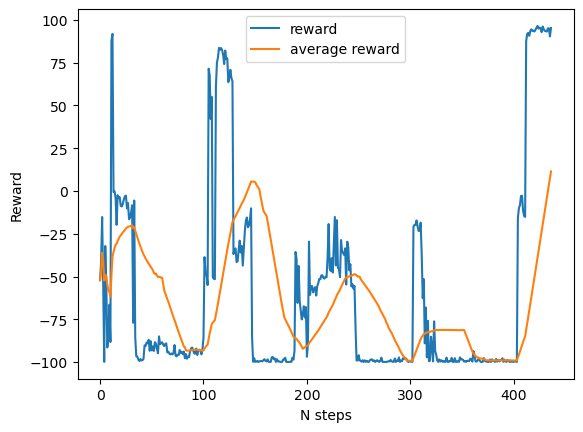

In [11]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N steps')
plt.ylabel('Reward')
plt.legend()
plt.show()

### Actor-Critic

In [12]:
class GenericNet(nn.Module):
    def __init__(self, lr, input_dims, n_actions, hidden1_dim=64, hidden2_dim=64):
        super(GenericNet, self).__init__()
        self.lr = lr
        self.input_dims = input_dims
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.n_actions = n_actions 
        self.layer1 = nn.Linear(*self.input_dims, self.hidden1_dim)
        self.layer2 = nn.Linear(self.hidden1_dim, self.hidden2_dim)
        self.layer3 = nn.Linear(self.hidden2_dim, self.n_actions)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.optimizer =  torch.optim.AdamW(self.parameters(), lr=self.lr)
        self.to(self.device)

    def forward(self, observ):
        #print('S', s.shape, s)
        #print('A', a.shape)
        outs = torch.tensor(observ, dtype = torch.float).to(device)
        #print(outs.shape)
        outs = F.relu(self.layer1(outs))
        outs = F.relu(self.layer2(outs)) 
        outs = self.layer3(outs)
        return outs

In [13]:
class Agent(object):
    def __init__(self, actor_lr, critic_lr, input_dims, n_actions=2, 
                 gamma = .99, hidden1_dim=64, hidden2_dim=64, n_outputs = 1):
        self.gamma = gamma
        self.log_probs = None
        self.n_outs = n_outputs
        self.actor = GenericNet(actor_lr, input_dims, hidden1_dim=64, hidden2_dim=64, n_actions=n_actions)
        self.critic = GenericNet(critic_lr, input_dims, hidden1_dim=64, hidden2_dim=64, n_actions=1)
    
    def choose_action(self, observ):
        mu, sigma = self.actor.forward(observ)
        sigma = torch.exp(sigma)
        action_probs = torch.distributions.Normal(mu, sigma)
        probs = action_probs.sample(sample_shape = torch.Size([self.n_outs]))
        self.log_probs = action_probs.log_prob(probs).to(self.actor.device)
        action = torch.tanh(probs)
        return action.item()

    def learn(self, state, reward, new_state, done):
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()

        critic_val_ = self.critic.forward(new_state)
        critic_val = self.critic.forward(state)
        reward = torch.tensor(reward, dtype = torch.float).to(self.actor.device)
        delta = reward + self.gamma*critic_val_*(1-int(done)) - critic_val
        actor_loss = -self.log_probs*delta
        critic_loss = delta**2
        (actor_loss +critic_loss).backward()
        self.actor.optimizer.step()
        self.critic.optimizer.step()

In [14]:
agent = Agent(actor_lr = (1e-5)/2, critic_lr=1e-5, input_dims=[2], 
              gamma = .99, hidden1_dim=512, hidden2_dim=256)
env = gym.make("MountainCarContinuous-v0") 
score_hist = []
n_epoch = 5000
for i in range(n_epoch):
    # Run episode till done
    s = env.reset()[0]
    done = False
    score = 0
    while not done:
        #print(s)
        a = np.array(agent.choose_action(s)).reshape((1,))
        #print(a)
        a = a.reshape((1,))
        #print(a)
        s_next, r, terminated, trunk, _ = env.step(a)
        done = terminated or trunk
        agent.learn(s, r, s_next, done)
        s = s_next
        score +=r
        score_hist.append(score)
    if (i+1)%100 == 0:
        print('episode  ', i+1, 'score = ', score)
    #filename = 'mc-c.png'
    #plotLearning(

episode   100 score =  -0.7112619177365678
episode   200 score =  -0.4498392508871687
episode   300 score =  -0.582415284954528
episode   400 score =  -0.18648505670993187
episode   500 score =  -0.2433917755302466
episode   600 score =  -0.19353512381542373
episode   700 score =  -0.3526401928849981
episode   800 score =  -1.1183616037565574
episode   900 score =  -0.5608136434550403
episode   1000 score =  -0.14299365100584693
episode   1100 score =  -0.16186236330251688
episode   1200 score =  -1.099711642074184
episode   1300 score =  -1.1027387298509275
episode   1400 score =  -0.6625435021299559
episode   1500 score =  -0.06075497907095444
episode   1600 score =  -0.2017432262537722
episode   1700 score =  -0.03221499036126613
episode   1800 score =  -0.04606540474846533
episode   1900 score =  -0.11973718605473259
episode   2000 score =  -0.08363222492072293
episode   2100 score =  -0.7135202481112357
episode   2200 score =  -3.4156668207814866
episode   2300 score =  -1.2180597

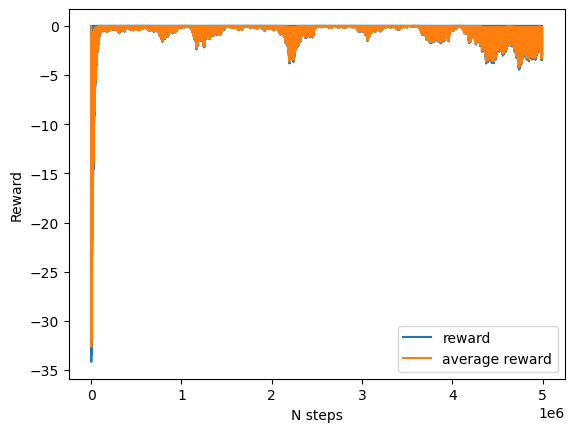

In [15]:
import matplotlib.pyplot as plt
# Generate recent 100 interval average
average_reward = []
for idx in range(len(score_hist)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 100:
        avg_list = score_hist[:idx+1]
    else:
        avg_list = score_hist[idx-99:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(score_hist, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N steps')
plt.ylabel('Reward')
plt.legend()
plt.show()

## [Optional] Clipped double-Q learning (Twin-Q)

In advanced algorithms, such as TD3 (Twin Delayed DDPG), 2 Q-networks - $ Q_{\phi_1}(s, a), Q_{\phi_2}(s, a) $ - and corresponding 2 target networks - $ Q_{\phi_1^{\prime}}(s, a), Q_{\phi_2^{\prime}}(s, a) $ - are used to optimize in order to mitigate the risk of overestimation in Q-function.

In this double-Q algorithms, we optimize parameters as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \theta $ to maximize $Q_{\phi_1}(s, \mu_{\theta}(s))$

And update target parameters as follows :

- $ \phi_1^{\prime} = \tau \phi_1 + (1-\tau) \phi_1^{\prime} $
- $ \phi_2^{\prime} = \tau \phi_2 + (1-\tau) \phi_2^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

(1) First, regenerate Q-network and policy network as follows.

In [16]:
q_origin_model1 = QNet(n_states+n_actions, hidden_dim).to(device)  # Q_phi1
q_origin_model2 = QNet(n_states+n_actions, hidden_dim).to(device)  # Q_phi2
q_target_model1 = QNet(n_states+n_actions, hidden_dim).to(device)  # Q_phi1'
q_target_model2 = QNet(n_states+n_actions, hidden_dim).to(device)  # Q_phi2'
_ = q_target_model1.requires_grad_(False)  # target model doen't need grad
_ = q_target_model2.requires_grad_(False)  # target model doen't need grad

In [17]:
mu_origin_model = PolicyNet(n_states, hidden_dim).to(device)  # mu_theta
mu_target_model = PolicyNet(n_states, hidden_dim).to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

In [18]:
gamma = 0.99


def optimize(states, actions, rewards, next_states, dones, lr = 0.0005):
    opt_q1 = torch.optim.AdamW(q_origin_model1.parameters(), lr=lr)
    opt_q2 = torch.optim.AdamW(q_origin_model2.parameters(), lr=lr)
    opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=lr)
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Compute r + gamma * (1 - done) * min Q (s_next, mu_target(s_next))
    mu_tgt_next = mu_target_model(next_states)
    q1_tgt_next = q_target_model1(next_states, mu_tgt_next)
    q2_tgt_next = q_target_model2(next_states, mu_tgt_next)
    q_tgt_next_min = torch.minimum(q1_tgt_next, q2_tgt_next)
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next_min

    # Optimize critic loss for Q-network1
    opt_q1.zero_grad()
    if actions.shape == (250, 1, 1):
        #print('A', a.shape)
        actions = torch.squeeze(actions, 2)
    q1_org = q_origin_model1(states, actions)
    loss_q1 = F.mse_loss(
        q1_org,
        q_tgt,
        reduction="none")
    loss_q1.sum().backward()
    opt_q1.step()

    # Optimize critic loss for Q-network2
    opt_q2.zero_grad()
    if actions.shape == (250, 1, 1):
        #print('A', a.shape)
        actions = torch.squeeze(actions, 2)
    q2_org = q_origin_model2(states, actions)
    loss_q2 = F.mse_loss(
        q2_org,
        q_tgt,
        reduction="none")
    loss_q2.sum().backward()
    opt_q2.step()

    # Optimize actor loss
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    for p in q_origin_model1.parameters():
        p.requires_grad = False # disable grad in q_origin_model1 before computation
    q_tgt_max = q_origin_model1(states, mu_org)
    (-q_tgt_max).sum().backward()
    opt_mu.step()
    for p in q_origin_model1.parameters():
        p.requires_grad = True # enable grad again

(3) Regenerate update target's params function.

In [19]:
#tau = 0.02

def update_target(tau):
    for var, var_target in zip(q_origin_model1.parameters(), q_target_model1.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(q_origin_model2.parameters(), q_target_model2.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

(4) Let's start training again !

In [20]:
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

buffer = replayBuffer(buffer_size=500000)

log_dir = "./TD3_MCC/"
os.makedirs(log_dir, exist_ok=True)

reward_records = [] 
n_epoch = 3000
positive_reward = 0
neg_reward_duration = 0
for i in range(n_epoch):
    s = env.reset()[0]
    done = False
    cum_reward = 0
    if positive_reward == 0:
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.5, theta=.25, dt=1e-2)
    else:
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.001, theta=.10, dt=1e-4)
    while not done:
        noise = ou_action_noise()
        a = pick_sample(s, noise)
        s_next, r, terminated, trunk, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            if positive_reward == 0:
                optimize(states, actions, rewards, next_states, dones, lr =0.005)
                tau = (n_epoch-i-1)/n_epoch
            else:
                optimize(states, actions, rewards, next_states, dones, lr =0.0005)
                tau = 0.001
            update_target(tau)
        s = s_next
        done = terminated or trunk
    if (i+1)%100 == 0:
        print("Run episode {} with rewards {}".format(i+1, cum_reward))
    reward_records.append(cum_reward)
    if cum_reward > 0:
        print('суммарное вознагр. за эпизод, если положительно', cum_reward)
        print('Лучший сохраненный результат', positive_reward)
    if cum_reward > positive_reward:
        positive_reward = cum_reward
        torch.save(q_origin_model.state_dict(), log_dir+'q_origin_model1.pth')
        torch.save(q_origin_model.state_dict(), log_dir+'q_origin_model2.pth')
        torch.save(mu_origin_model.state_dict(), log_dir+'mu_origin_model.pth')
        update_target(tau=1)
    
    if np.average(reward_records[-50:]) > 20.0:
        break
    else: 
        neg_reward_duration +=1
        
    if positive_reward > 0 and neg_reward_duration > 100:
        print('Обучение не прогрессирует 100 эпох, перезагрузка лучшего сохранения')
        q_origin_model1.load_state_dict(torch.load(log_dir+'q_origin_model1.pth', weights_only=False))
        q_origin_model2.load_state_dict(torch.load(log_dir+'q_origin_model2.pth', weights_only=False))
        mu_origin_model.load_state_dict(torch.load(log_dir+'mu_origin_model.pth', weights_only=False))
        neg_reward_duration = 0
print("\nDone")

суммарное вознагр. за эпизод, если положительно 69.63543560610961
Лучший сохраненный результат 0
суммарное вознагр. за эпизод, если положительно 53.12978419894066
Лучший сохраненный результат 69.63543560610961
суммарное вознагр. за эпизод, если положительно 78.49604683592966
Лучший сохраненный результат 69.63543560610961
суммарное вознагр. за эпизод, если положительно 77.99412234751021
Лучший сохраненный результат 78.49604683592966
суммарное вознагр. за эпизод, если положительно 83.27690429973636
Лучший сохраненный результат 78.49604683592966
суммарное вознагр. за эпизод, если положительно 64.70733471625195
Лучший сохраненный результат 83.27690429973636
Run episode 100 with rewards -99.85731924238198
Обучение не прогрессирует 100 эпох, перезагрузка лучшего сохранения
суммарное вознагр. за эпизод, если положительно 59.974042998771566
Лучший сохраненный результат 83.27690429973636
суммарное вознагр. за эпизод, если положительно 46.41671801789512
Лучший сохраненный результат 83.2769042997

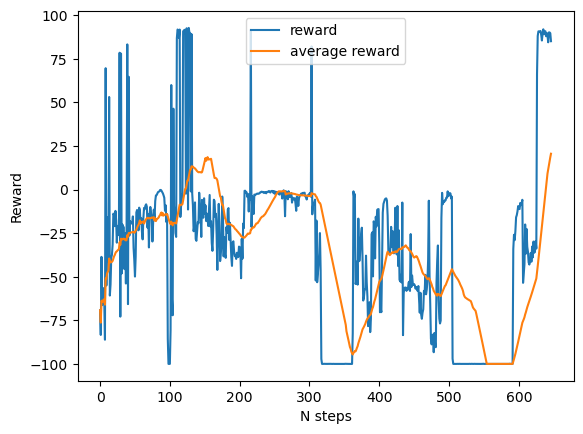

In [21]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N steps')
plt.ylabel('Reward')
plt.legend()
plt.show()